<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/notebooks/analyze_exp_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive

In [4]:
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/concept_learning/concept_learning

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/concept_learning/concept_learning'
/content/gdrive/MyDrive/concept_learning/concept_learning


In [5]:
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"

In [5]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/sunilvengalil/concept_learning
   461e1b1..3b3c4da  master     -> origin/master
Updating 461e1b1..3b3c4da
Fast-forward
 clearn/analysis/plot_metrics.py | 13 +++++--------
 1 file changed, 5 insertions(+), 8 deletions(-)


In [6]:
import tensorflow as tf
from clearn.config import ExperimentConfig
from clearn.dao.dao_factory import get_dao
from clearn.experiments.experiment import initialize_model_train_and_get_features, MODEL_TYPE_VAE_SEMI_SUPERVISED_CIFAR10

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
experiment_name = "Experiment_5"
z_dim = 64
num_units = [64, 128, 64, 64]
#num_units = [128, 256, 512, 1024]
learning_rate = 1e-3
num_epochs = 100
num_runs = 1
create_split = True
run_id = 2
num_cluster_config = ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW
train_val_data_iterator = None
beta = 0
supervise_weight = 0
reconstruction_weight = 1
dataset_name = "cifar_10"
split_name = "split_1"
num_val_samples = 5000
dao = get_dao(dataset_name, split_name, num_val_samples)

In [8]:
from clearn.analysis.plot_metrics import plot_epoch_vs_accuracy
from matplotlib import pyplot as plt

In [45]:
from clearn.dao.dao_factory import get_dao
from typing import List
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from clearn.utils.dir_utils import get_eval_result_dir
import cv2

def read_accuracy_from_file(file_prefix):
    df = None
    print(file_prefix)
    for file in glob.glob(file_prefix):
        print(file_prefix, file)
        temp_df = pd.read_csv(file)
        if df is None:
            df = temp_df
        else:
            pd.concat([df, temp_df], axis=1)
    return df

def plot_epoch_vs_metric(root_path: str,
                         experiment_name: str,
                         num_units: List[int],
                         num_cluster_config: str,
                         z_dim: int,
                         run_id: int,
                         dataset_types: List[str]=["train", "test"],
                         activation_output_layer="SIGMOID",
                         dataset_name="mnist",
                         split_name="Split_1",
                         batch_size=64,
                         num_val_samples=128,
                         num_decoder_layer=4,
                         metrics: List[str]=["accuracy"],
                         legend_loc="best",
                         show_sample_images=True
                         ):
    colors = ['r', 'g', 'b', 'y']
    dao = get_dao(dataset_name, split_name, num_val_samples)
    exp_config = ExperimentConfig(root_path=root_path,
                                  num_decoder_layer=num_decoder_layer,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  activation_output_layer=activation_output_layer
                                  )
    exp_config.check_and_create_directories(run_id, False)
    file_prefix = "/metrics_*.csv"
    df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
    ax = [None] * len(metrics)
    plots = [None] * (len(metrics) * len(dataset_types))
    plot_number = 0
    fig = plt.figure(figsize=[20,10])
    for i, metric in enumerate(metrics):
        if i == 0:
            main_axis = plt.subplot(1, 2, 1)
            ax[i] = main_axis
        else:
            ax[i] = main_axis.twinx()

        for dataset_type in dataset_types:
            plots[plot_number], = ax[i].plot(df["epoch"],
                                             df[f"{dataset_type}_{metric}"],
                                             colors[plot_number],
                                             label=f"{dataset_type}_{metric}")
            plot_number += 1
        plt.ylabel(metric.title())
        plt.xlabel("Epochs")
    if show_sample_images:
      im_ax = plt.subplot(1,2,2)
      _num_epochs_trained = df["epoch"].max()
      _num_batches_train = dao.number_of_training_samples // exp_config.BATCH_SIZE

      reconstructed_dir = get_eval_result_dir(exp_config.PREDICTION_RESULTS_PATH,
                                              _num_epochs_trained,
                                              _num_batches_train)
      print(reconstructed_dir)
      sample_image = cv2.imread(reconstructed_dir + "/im_0.png")
      im_ax.imshow( sample_image )
      
    main_axis.legend(handles=plots,
                     labels=[l.get_label() for l in plots],
                     loc=legend_loc,
                     shadow=True,
                     fontsize='x-large')
    plt.suptitle(f"Number of units {num_units} z_dim = {z_dim}")
    plt.grid()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis/metrics_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_96_0703/
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_le

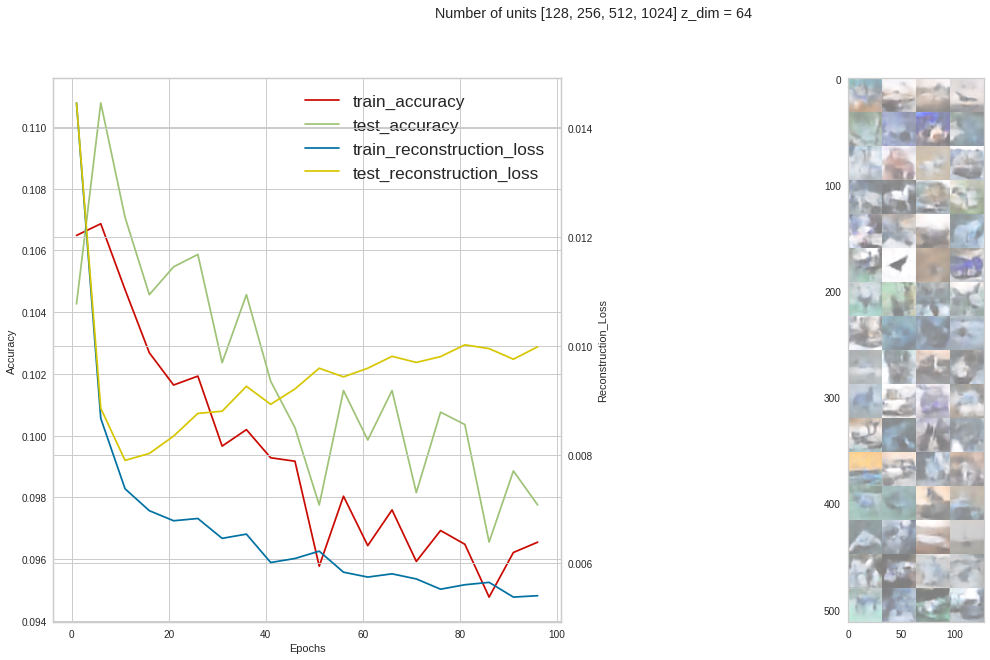

<Figure size 576x396 with 0 Axes>

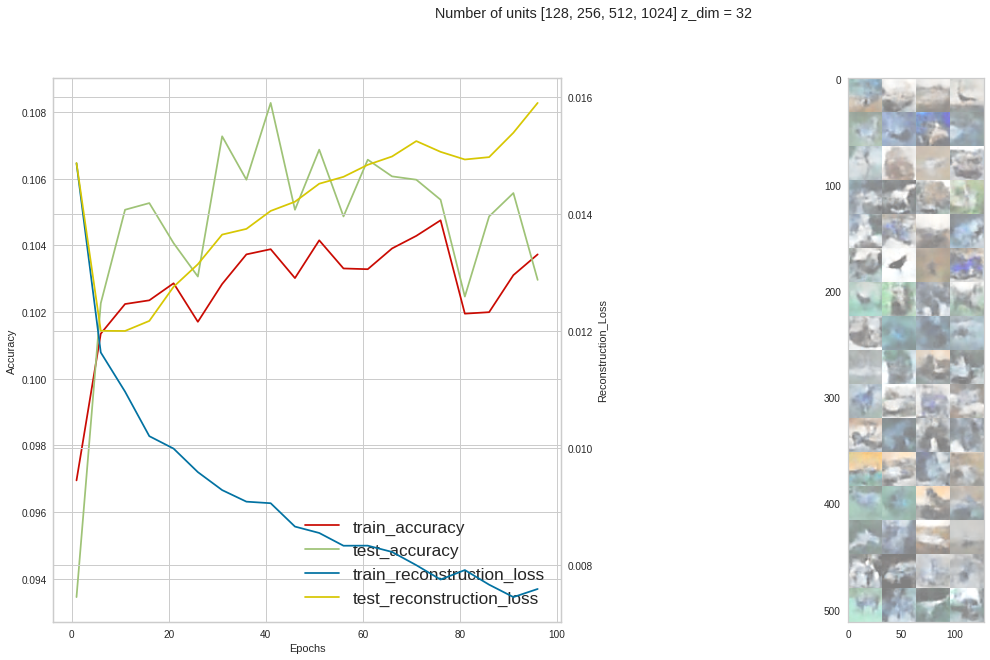

In [47]:
z_dim = 64
num_units = [128, 256, 512, 1024]
plot_epoch_vs_metric(root_path=root_path,
                       experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metrics=["accuracy", "reconstruction_loss"],
                       legend_loc = "upper right"
                           )
plt.figure()
z_dim = 32
plot_epoch_vs_metric(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metrics=["accuracy", "reconstruction_loss"]
                           )


In [70]:
# Simple Model

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis/metrics_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_96_0703/
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/

<Figure size 576x396 with 0 Axes>

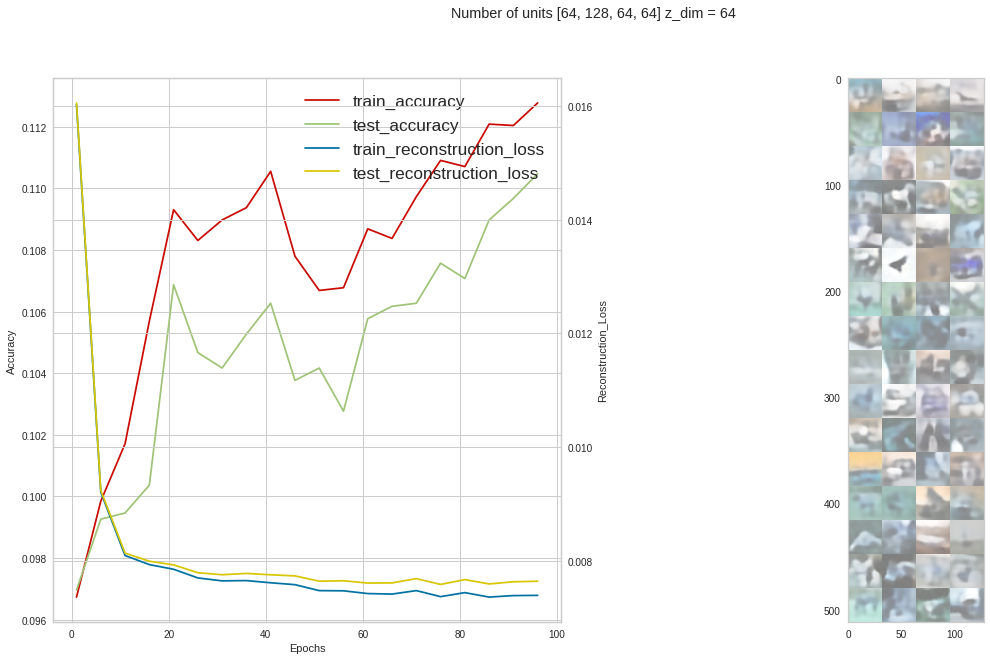

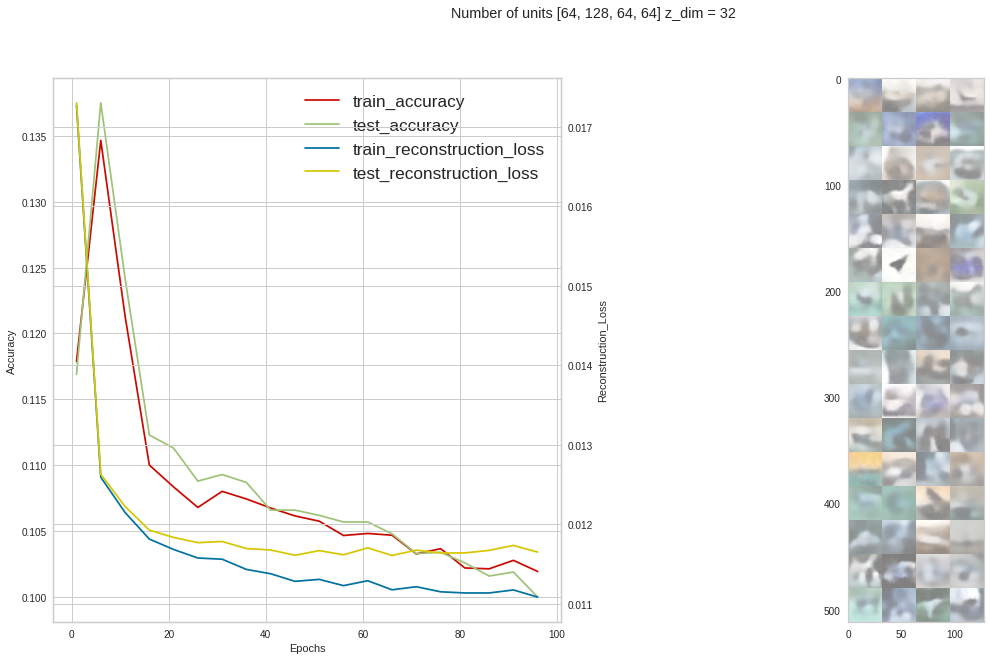

In [48]:
num_units = [64, 128, 64, 64]
plt.figure()
plot_epoch_vs_metric(root_path=root_path,
                       experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=64,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metrics=["accuracy", "reconstruction_loss"],
                       legend_loc = "upper right"
                           )

plot_epoch_vs_metric(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=32,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metrics=["accuracy", "reconstruction_loss"]
)

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_64_TWO_TIMES_ELBOW_2/analysis/metrics_0.csv
(20, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_32_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_64_64_128_64_32_TWO_TIMES_ELBOW_2/analysis/metrics_0.csv
(20, 7)
train
test


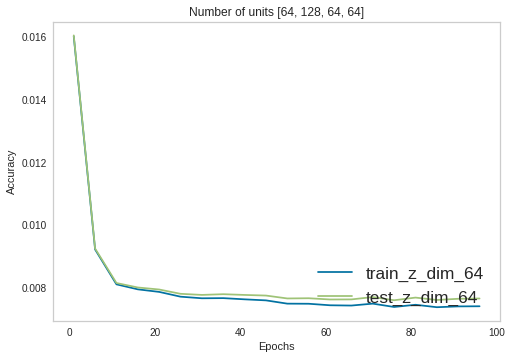

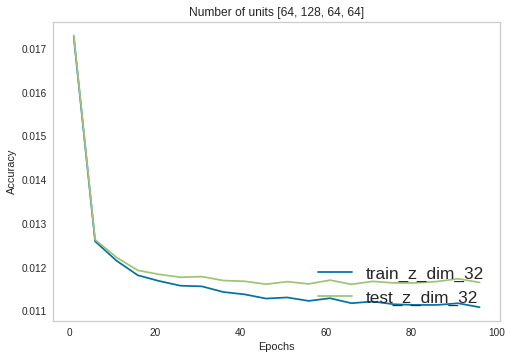

In [12]:

plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=64,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metric="reconstruction_loss"
                           )
plt.figure()

plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=32,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metric="reconstruction_loss"
                           )



/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis//metrics_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_5/Exp_1024_512_256_128_64_TWO_TIMES_ELBOW_2/analysis/metrics_0.csv
(20, 7)
train
test


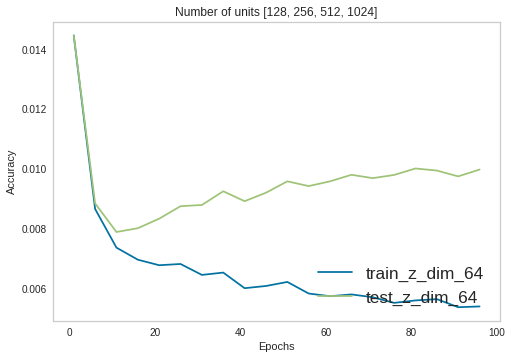

In [13]:
num_units = [128, 256, 512, 1024]
plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=64,
                           run_id=run_id,
                           dataset_types = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=64,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=len(num_units)+1,
                       metric="reconstruction_loss"
                           )


In [13]:
num_units = [128, 256, 512, 1024]
plot_z_dim_vs_accuracy(root_path=root_path,
                       experiment_name=experiment_name,
                       z_dim_range=[32,34],
                       num_units=num_units,
                       num_cluster_config=num_cluster_config,
                       num_epochs=num_epochs,
                       run_id=run_id,
                       split_name=split_name,
                       num_val_samples=num_val_samples,
                       activation_output_layer="LINEAR",
                       dataset_name=dataset_name,
                       batch_size=64,
                       num_decoder_layer=len(num_units)
                       )

NameError: ignored